# <b>1 <span style='color:#4285f4'>|</span>Importing the required libraries</b>

In [1]:
# Importing the necessary libraries/packages for the project
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# More libraries/packages
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Data visualiation packages
import matplotlib.pyplot as plt
import seaborn as sns

# Others
from tqdm import tqdm
import os
import random

# <b>2 <span style='color:#4285f4'>|</span>Reading the Training and Testing Dataset</b>

In [2]:
train_dir = './Dataset/Training/'
test_dir = './Dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [3]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

([<matplotlib.patches.Wedge at 0x7f8d160512a0>,
 [Text(-1.1477294392716355, 0.07222973230753062, 'Train'),
  Text(1.0978281528346907, -0.0690894119498146, 'Test')],
 [Text(-0.6487166395883155, 0.04082550086947383, '81.3%'),
  Text(0.5988153560916494, -0.03768513379080796, '18.7%')])

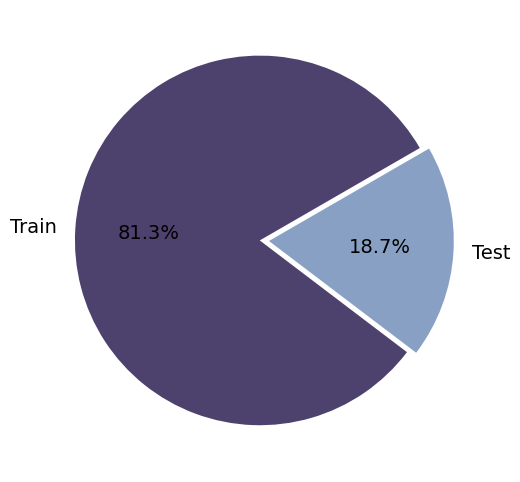

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4d416d','#88a0c3','#d3e7ff','#90d3e4']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30)

***Pre-Processing steps to implement Transfer Learning Models***
1. Augmentation of Dataset
2. Implementing VGG16, InceptionV3 and Resnet50 models

# <b>3 <span style='color:#4285f4'>|</span> Augementation of the Dataset</b>
Taking an image as input and returning a modified version of the input image.
- Enhancing/Diminishing the brightness of the images
- Enhancing/Diminishing the contrast of the images


In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;">Plotting the images for testing</h3>

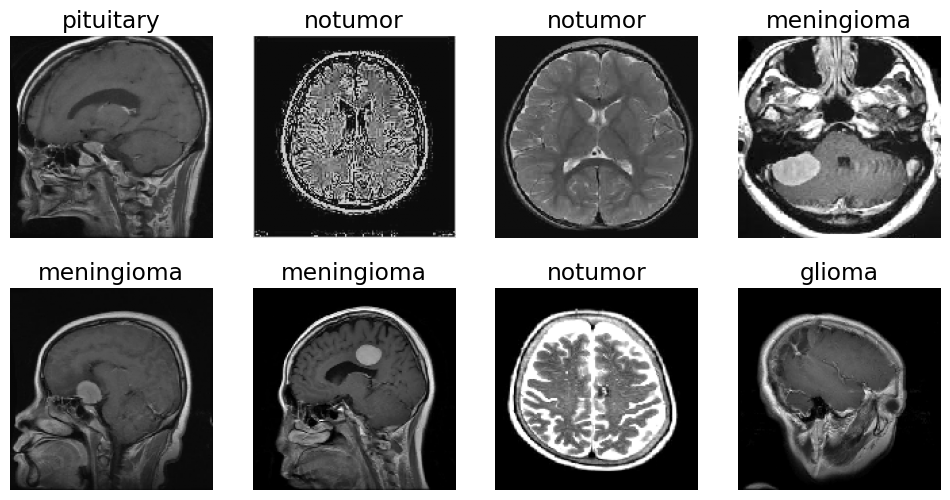

In [7]:
IMAGE_SIZE = 140

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# <b>4 <span style='color:#4285f4'>|</span>Data Preprocessing and Batch Generation for Machine Learning Training</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Here we have defined few functions to help with data preprocessing and generating batches of data for training a machine learning model.<br>
    1. encode_label(labels):  This function takes a list of label names and returns a NumPy array of integers representing the encoded labels. The encoding is based on the unique_labels list, with each label name being mapped to its corresponding index in the list. <br>
    2. decode_label(labels) - This function takes a NumPy array of encoded labels and returns a list of the original label names. The decoding is based on the unique_labels list, with each encoded label index being mapped to its corresponding label name. <br>
    3. datagen(paths, labels, batch_size=12, epochs=1) - This function is a generator that yields batches of image data and corresponding labels. <br>
    <br>
</p>

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b>5 <span style='color:#4285f4'>|</span>Implementation of Transfer Learning Models</b>

**1. VGG16 MODEL**

The code defines a Keras model using the VGG16 architecture for transfer learning. The pre-trained VGG16 model is loaded and added as a layer in a Sequential model, followed by a Flatten layer, two Dropout layers, and two Dense layers. The final layer uses a softmax activation function to output predicted class probabilities.

In [14]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [15]:
# VGG16 Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [17]:
# VGG16 Model compiling
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [18]:
# VGG16 Model training
batch_size = 18
steps = int(len(train_paths)/batch_size)
epochs = 6
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/6
317/317 [==============================] - 702s 2s/step - loss: 0.4206 - sparse_categorical_accuracy: 0.8384
Epoch 2/6
317/317 [==============================] - 775s 2s/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9192
Epoch 3/6
317/317 [==============================] - 880s 3s/step - loss: 0.1397 - sparse_categorical_accuracy: 0.9475
Epoch 4/6
317/317 [==============================] - 820s 3s/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9647
Epoch 5/6
317/317 [==============================] - 780s 2s/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9708
Epoch 6/6
317/317 [==============================] - 825s 3s/step - loss: 0.0688 - sparse_categorical_accuracy: 0.9747


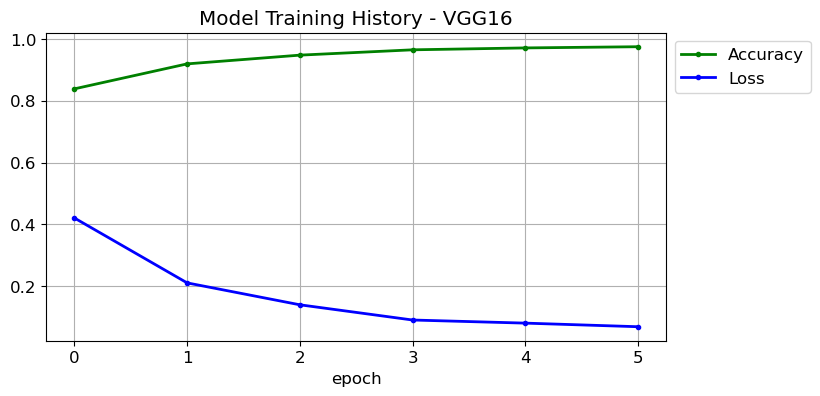

In [25]:
# Ploting the training history of the VGG16 model using Matplotlib.
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.b-', linewidth=2)
plt.title('Model Training History - VGG16')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
# Model evaluation with test samples
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|▎         | 1/40 [00:03<02:17,  3.52s/it]

1/1 [==============================] - 3s 3s/step


  5%|▌         | 2/40 [00:06<02:02,  3.22s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 3/40 [00:09<01:56,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 10%|█         | 4/40 [00:12<01:51,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▎        | 5/40 [00:15<01:47,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 6/40 [00:18<01:45,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 7/40 [00:21<01:42,  3.09s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 8/40 [00:25<01:39,  3.10s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▎       | 9/40 [00:28<01:36,  3.11s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 10/40 [00:31<01:34,  3.14s/it]

1/1 [==============================] - 4s 4s/step


 28%|██▊       | 11/40 [00:35<01:36,  3.32s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 12/40 [00:38<01:34,  3.39s/it]

1/1 [==============================] - 4s 4s/step


 32%|███▎      | 13/40 [00:42<01:33,  3.47s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▌      | 14/40 [00:45<01:29,  3.45s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 15/40 [00:49<01:26,  3.47s/it]

1/1 [==============================] - 3s 3s/step


 40%|████      | 16/40 [00:52<01:22,  3.45s/it]

1/1 [==============================] - 4s 4s/step


 42%|████▎     | 17/40 [00:56<01:21,  3.52s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 18/40 [00:59<01:17,  3.52s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 19/40 [01:03<01:13,  3.49s/it]

1/1 [==============================] - 4s 4s/step


 50%|█████     | 20/40 [01:07<01:11,  3.59s/it]

1/1 [==============================] - 3s 3s/step


 52%|█████▎    | 21/40 [01:10<01:07,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▌    | 22/40 [01:14<01:04,  3.57s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▊    | 23/40 [01:17<01:00,  3.56s/it]

1/1 [==============================] - 4s 4s/step


 60%|██████    | 24/40 [01:21<00:58,  3.67s/it]

1/1 [==============================] - 4s 4s/step


 62%|██████▎   | 25/40 [01:25<00:54,  3.66s/it]

1/1 [==============================] - 4s 4s/step


 65%|██████▌   | 26/40 [01:28<00:51,  3.64s/it]

1/1 [==============================] - 4s 4s/step


 68%|██████▊   | 27/40 [01:32<00:48,  3.71s/it]

1/1 [==============================] - 4s 4s/step


 70%|███████   | 28/40 [01:36<00:45,  3.83s/it]

1/1 [==============================] - 4s 4s/step


 72%|███████▎  | 29/40 [01:40<00:42,  3.87s/it]

1/1 [==============================] - 4s 4s/step


 75%|███████▌  | 30/40 [01:44<00:39,  3.91s/it]

1/1 [==============================] - 4s 4s/step


 78%|███████▊  | 31/40 [01:48<00:35,  3.91s/it]

1/1 [==============================] - 4s 4s/step


 80%|████████  | 32/40 [01:52<00:31,  3.92s/it]

1/1 [==============================] - 4s 4s/step


 82%|████████▎ | 33/40 [01:56<00:26,  3.86s/it]

1/1 [==============================] - 4s 4s/step


 85%|████████▌ | 34/40 [01:59<00:22,  3.78s/it]

1/1 [==============================] - 4s 4s/step


 88%|████████▊ | 35/40 [02:03<00:18,  3.73s/it]

1/1 [==============================] - 4s 4s/step


 90%|█████████ | 36/40 [02:07<00:14,  3.70s/it]

1/1 [==============================] - 4s 4s/step


 92%|█████████▎| 37/40 [02:10<00:11,  3.72s/it]

1/1 [==============================] - 4s 4s/step


 95%|█████████▌| 38/40 [02:14<00:07,  3.70s/it]

1/1 [==============================] - 4s 4s/step


 98%|█████████▊| 39/40 [02:18<00:03,  3.83s/it]

1/1 [==============================] - 4s 4s/step


100%|██████████| 40/40 [02:22<00:00,  3.84s/it]

1/1 [==============================] - 4s 4s/step


41it [02:26,  3.57s/it]                        


In [21]:
# Printing evaluation matrices for VGG16
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.95      0.95      0.95       300
  meningioma       0.95      0.94      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



Confusion Matrix


Text(97.2222222222222, 0.5, 'Predicted class')

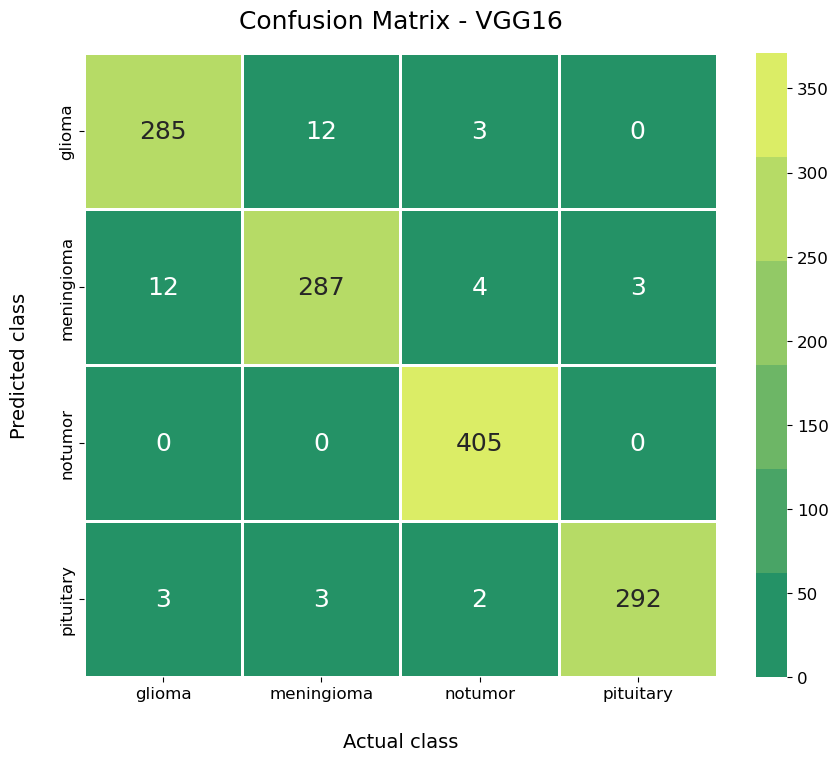

In [22]:
# Printing the confusion matrix for VGG16 Model
testDir = './Dataset/Testing'
classes = sorted(os.listdir(testDir))

print('Confusion Matrix - VGG16')
cm = confusion_matrix(y_true, y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("summer")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
plt.yticks(va="center")
plt.title('Confusion Matrix - VGG16',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

**INCEPTION MODEL**

Defining a Keras model using transfer learning with InceptionV3 architecture and compiles it with an Adam optimizer and sparse categorical cross-entropy loss. The model has a final classification layer with 4 output classes

In [58]:
# InceptionV3 model Implementation

# Loading the inceptionV3 model 
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
num_classes = 4

# Adding the layers to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Defining the inceptionV3 model
model_inception = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Model compilation
model_inception.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

# Defining a Keras callback that saves the model's weights to a file.
checkpoint = ModelCheckpoint('inceptionv3_brain_tumor.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Defining EarlyStopping to stop the training process if the validation accuracy does not improve for a certain number of epochs.
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1)

# Model Training with pre-defined hyperparameters
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 6
history_inception = model_inception.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[checkpoint, early_stop])

Epoch 1/6
285/285 [==============================] - 116s 397ms/step - loss: 0.6795 - sparse_categorical_accuracy: 0.7895
Epoch 2/6
285/285 [==============================] - 119s 419ms/step - loss: 0.3310 - sparse_categorical_accuracy: 0.8772
Epoch 3/6
285/285 [==============================] - 123s 433ms/step - loss: 0.2606 - sparse_categorical_accuracy: 0.8972
Epoch 4/6
285/285 [==============================] - 118s 414ms/step - loss: 0.2134 - sparse_categorical_accuracy: 0.9187
Epoch 5/6
285/285 [==============================] - 119s 417ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.9339
Epoch 6/6
285/285 [==============================] - 120s 422ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.9394


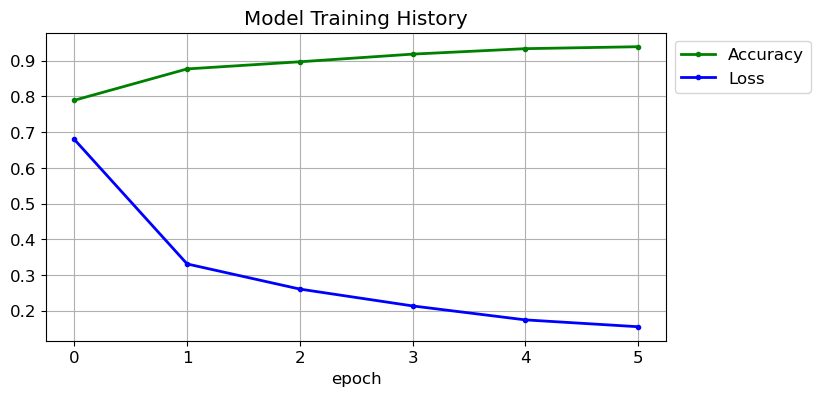

In [59]:
# Ploting the training history of the InceptionV3 model using Matplotlib.
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_inception.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_inception.history['loss'], '.b-', linewidth=2)
plt.title('Model Training History - InceptionV3')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [62]:
# Model evaluation with test samples
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model_inception.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 598ms/step


  2%|▎         | 1/40 [00:00<00:28,  1.38it/s]

1/1 [==============================] - 0s 488ms/step


  5%|▌         | 2/40 [00:01<00:24,  1.57it/s]

1/1 [==============================] - 1s 514ms/step


  8%|▊         | 3/40 [00:01<00:22,  1.62it/s]

1/1 [==============================] - 1s 514ms/step


 10%|█         | 4/40 [00:02<00:21,  1.64it/s]

1/1 [==============================] - 1s 501ms/step


 12%|█▎        | 5/40 [00:03<00:20,  1.67it/s]

1/1 [==============================] - 1s 716ms/step


 15%|█▌        | 6/40 [00:03<00:22,  1.50it/s]

1/1 [==============================] - 1s 749ms/step


 18%|█▊        | 7/40 [00:04<00:24,  1.37it/s]

1/1 [==============================] - 1s 575ms/step


 20%|██        | 8/40 [00:05<00:22,  1.41it/s]

1/1 [==============================] - 1s 567ms/step


 22%|██▎       | 9/40 [00:06<00:21,  1.45it/s]

1/1 [==============================] - 1s 549ms/step


 25%|██▌       | 10/40 [00:06<00:20,  1.49it/s]

1/1 [==============================] - 1s 567ms/step


 28%|██▊       | 11/40 [00:07<00:19,  1.51it/s]

1/1 [==============================] - 1s 577ms/step


 30%|███       | 12/40 [00:07<00:18,  1.52it/s]

1/1 [==============================] - 1s 551ms/step


 32%|███▎      | 13/40 [00:08<00:17,  1.53it/s]

1/1 [==============================] - 1s 519ms/step


 35%|███▌      | 14/40 [00:09<00:16,  1.57it/s]

1/1 [==============================] - 1s 559ms/step


 38%|███▊      | 15/40 [00:09<00:15,  1.57it/s]

1/1 [==============================] - 1s 584ms/step


 40%|████      | 16/40 [00:10<00:15,  1.55it/s]

1/1 [==============================] - 1s 594ms/step


 42%|████▎     | 17/40 [00:11<00:15,  1.52it/s]

1/1 [==============================] - 1s 534ms/step


 45%|████▌     | 18/40 [00:11<00:14,  1.55it/s]

1/1 [==============================] - 1s 530ms/step


 48%|████▊     | 19/40 [00:12<00:13,  1.58it/s]

1/1 [==============================] - 1s 529ms/step


 50%|█████     | 20/40 [00:13<00:12,  1.60it/s]

1/1 [==============================] - 1s 624ms/step


 52%|█████▎    | 21/40 [00:13<00:12,  1.54it/s]

1/1 [==============================] - 1s 552ms/step


 55%|█████▌    | 22/40 [00:14<00:11,  1.55it/s]

1/1 [==============================] - 1s 575ms/step


 57%|█████▊    | 23/40 [00:15<00:11,  1.54it/s]

1/1 [==============================] - 1s 569ms/step


 60%|██████    | 24/40 [00:15<00:10,  1.54it/s]

1/1 [==============================] - 1s 540ms/step


 62%|██████▎   | 25/40 [00:16<00:09,  1.56it/s]

1/1 [==============================] - 1s 544ms/step


 65%|██████▌   | 26/40 [00:16<00:08,  1.57it/s]

1/1 [==============================] - 1s 548ms/step


 68%|██████▊   | 27/40 [00:17<00:08,  1.58it/s]

1/1 [==============================] - 1s 545ms/step


 70%|███████   | 28/40 [00:18<00:07,  1.59it/s]

1/1 [==============================] - 1s 599ms/step


 72%|███████▎  | 29/40 [00:18<00:07,  1.55it/s]

1/1 [==============================] - 1s 638ms/step


 75%|███████▌  | 30/40 [00:19<00:06,  1.50it/s]

1/1 [==============================] - 1s 619ms/step


 78%|███████▊  | 31/40 [00:20<00:06,  1.47it/s]

1/1 [==============================] - 1s 548ms/step


 80%|████████  | 32/40 [00:20<00:05,  1.51it/s]

1/1 [==============================] - 1s 637ms/step


 82%|████████▎ | 33/40 [00:21<00:04,  1.48it/s]

1/1 [==============================] - 1s 563ms/step


 85%|████████▌ | 34/40 [00:22<00:04,  1.49it/s]

1/1 [==============================] - 1s 548ms/step


 88%|████████▊ | 35/40 [00:22<00:03,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 90%|█████████ | 36/40 [00:23<00:02,  1.52it/s]

1/1 [==============================] - 1s 551ms/step


 92%|█████████▎| 37/40 [00:24<00:01,  1.53it/s]

1/1 [==============================] - 1s 576ms/step


 95%|█████████▌| 38/40 [00:24<00:01,  1.53it/s]

1/1 [==============================] - 1s 554ms/step


 98%|█████████▊| 39/40 [00:25<00:00,  1.55it/s]

1/1 [==============================] - 1s 552ms/step


100%|██████████| 40/40 [00:26<00:00,  1.56it/s]

1/1 [==============================] - 1s 574ms/step


41it [00:26,  1.53it/s]                        


In [63]:
# Printing evaluation matrices for InceptionV3 model
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.99      0.66      0.79       300
  meningioma       0.76      0.86      0.81       306
     notumor       0.88      1.00      0.94       405
   pituitary       0.92      0.95      0.93       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.87      1311
weighted avg       0.89      0.88      0.87      1311



Confusion Matrix


Text(97.2222222222222, 0.5, 'Predicted class')

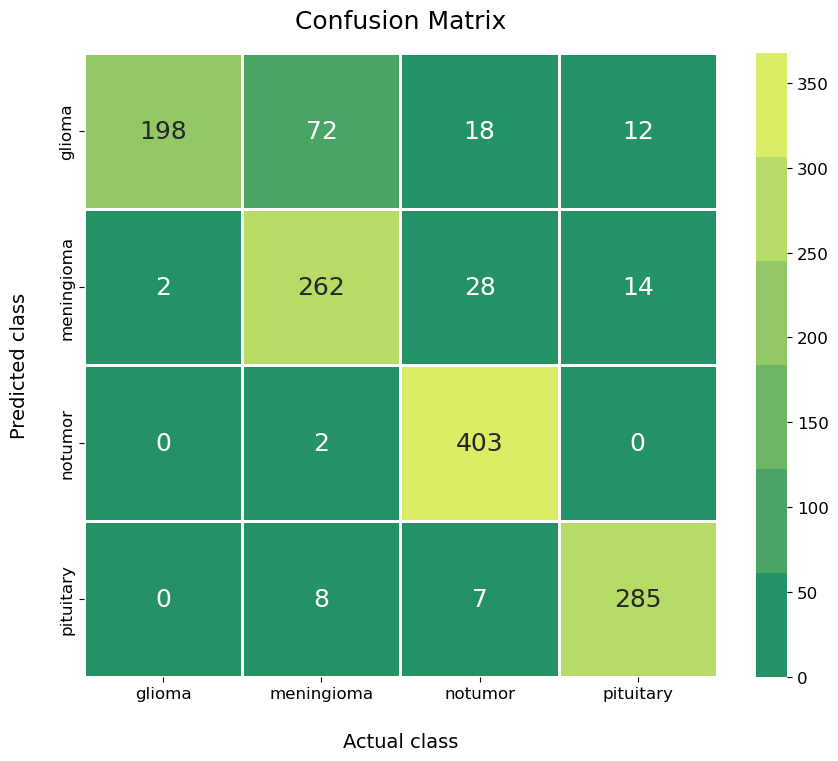

In [64]:
# Printing the confusion matrix for InceptionV3 Model
testDir = './Dataset/Testing'
classes = sorted(os.listdir(testDir))

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("summer")  
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
plt.yticks(va="center")
plt.title('Confusion Matrix - InceptionV3',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [66]:
# InceptionV3 Model Summary
model_inception.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1410 (Conv2D)           (None, 74, 74, 32)   864         ['input_17[0][0]']               
                                                                                                  
 batch_normalization_1410 (Batc  (None, 74, 74, 32)  96          ['conv2d_1410[0][0]']            
 hNormalization)                                                                                  
                                                                                           

**RESNET MODEL**

Defining a Keras model using the ResNet50 architecture for transfer learning. The pre-trained ResNet50 model is loaded without the final classification layer, and a new classification layer is added with 4 output classes. The model is then compiled with an Adam optimizer and sparse categorical cross-entropy loss.

In [40]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

num_classes = 4
predictions = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Printing the Resnet50 model summary
model_resnet.summary()    

# Compiling Resnet50 model 
model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [48]:
# Defining a Keras callback that saves the model's weights to a file.
checkpoint_resnet = ModelCheckpoint('resnet50_brain_tumor.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Defining EarlyStopping to stop the training process if the validation accuracy does not improve for a certain number of epochs.
early_stop_resnet = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1)

# Training the Resnet50 model
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 6

history_resnet = model_resnet.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/6
285/285 [==============================] - 350s 1s/step - loss: 0.5454 - sparse_categorical_accuracy: 0.7765
Epoch 2/6
285/285 [==============================] - 207s 727ms/step - loss: 0.5359 - sparse_categorical_accuracy: 0.7799
Epoch 3/6
285/285 [==============================] - 216s 758ms/step - loss: 0.5350 - sparse_categorical_accuracy: 0.7790
Epoch 4/6
285/285 [==============================] - 223s 784ms/step - loss: 0.5307 - sparse_categorical_accuracy: 0.7909
Epoch 5/6
285/285 [==============================] - 236s 828ms/step - loss: 0.5215 - sparse_categorical_accuracy: 0.7871
Epoch 6/6
285/285 [==============================] - 3022s 11s/step - loss: 0.5149 - sparse_categorical_accuracy: 0.7901


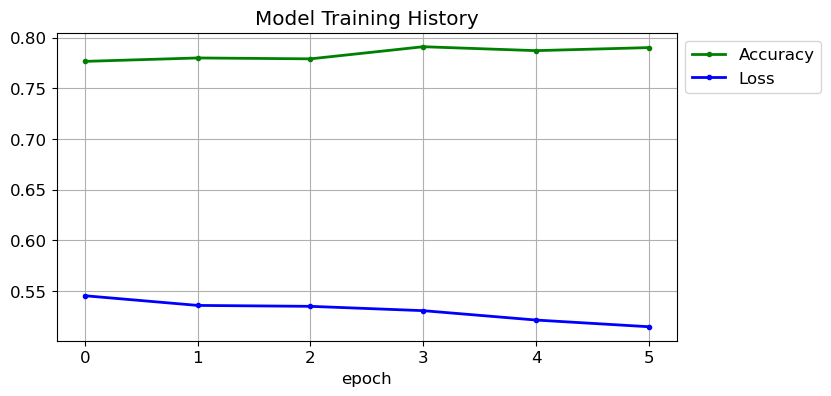

In [49]:
# Ploting the training history of the Resnet50 model using Matplotlib.
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_resnet.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_resnet.history['loss'], '.b-', linewidth=2)
plt.title('Model Training History - Resnet50')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [51]:
# Model evaluation with test samples
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model_resnet.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:02<01:39,  2.56s/it]

1/1 [==============================] - 1s 914ms/step


  5%|▌         | 2/40 [00:03<01:02,  1.65s/it]

1/1 [==============================] - 1s 982ms/step


  8%|▊         | 3/40 [00:04<00:51,  1.39s/it]

1/1 [==============================] - 1s 968ms/step


 10%|█         | 4/40 [00:05<00:45,  1.27s/it]

1/1 [==============================] - 1s 963ms/step


 12%|█▎        | 5/40 [00:06<00:41,  1.19s/it]

1/1 [==============================] - 1s 930ms/step


 15%|█▌        | 6/40 [00:07<00:38,  1.13s/it]

1/1 [==============================] - 1s 912ms/step


 18%|█▊        | 7/40 [00:08<00:35,  1.08s/it]

1/1 [==============================] - 1s 946ms/step


 20%|██        | 8/40 [00:09<00:34,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▎       | 9/40 [00:10<00:34,  1.10s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 10/40 [00:12<00:37,  1.25s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 11/40 [00:14<00:38,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 12/40 [00:15<00:37,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▎      | 13/40 [00:16<00:36,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▌      | 14/40 [00:17<00:33,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 15/40 [00:18<00:30,  1.22s/it]

1/1 [==============================] - 1s 955ms/step


 40%|████      | 16/40 [00:20<00:28,  1.17s/it]

1/1 [==============================] - 1s 933ms/step


 42%|████▎     | 17/40 [00:21<00:25,  1.12s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 18/40 [00:22<00:25,  1.15s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 19/40 [00:23<00:24,  1.15s/it]

1/1 [==============================] - 1s 919ms/step


 50%|█████     | 20/40 [00:24<00:22,  1.10s/it]

1/1 [==============================] - 1s 984ms/step


 52%|█████▎    | 21/40 [00:25<00:20,  1.09s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 22/40 [00:26<00:20,  1.13s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▊    | 23/40 [00:27<00:19,  1.14s/it]

1/1 [==============================] - 1s 910ms/step


 60%|██████    | 24/40 [00:28<00:17,  1.10s/it]

1/1 [==============================] - 1s 968ms/step


 62%|██████▎   | 25/40 [00:29<00:16,  1.09s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 26/40 [00:31<00:18,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 27/40 [00:32<00:16,  1.26s/it]

1/1 [==============================] - 1s 962ms/step


 70%|███████   | 28/40 [00:33<00:14,  1.19s/it]

1/1 [==============================] - 1s 946ms/step


 72%|███████▎  | 29/40 [00:34<00:12,  1.14s/it]

1/1 [==============================] - 1s 1000ms/step


 75%|███████▌  | 30/40 [00:36<00:11,  1.13s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 31/40 [00:37<00:10,  1.15s/it]

1/1 [==============================] - 1s 959ms/step


 80%|████████  | 32/40 [00:38<00:08,  1.11s/it]

1/1 [==============================] - 1s 936ms/step


 82%|████████▎ | 33/40 [00:39<00:07,  1.08s/it]

1/1 [==============================] - 1s 926ms/step


 85%|████████▌ | 34/40 [00:40<00:06,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 35/40 [00:41<00:05,  1.16s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 36/40 [00:42<00:04,  1.19s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▎| 37/40 [00:44<00:03,  1.19s/it]

1/1 [==============================] - 1s 951ms/step


 95%|█████████▌| 38/40 [00:45<00:02,  1.14s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 39/40 [00:46<00:01,  1.17s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 40/40 [00:47<00:00,  1.17s/it]

1/1 [==============================] - 2s 2s/step


41it [00:49,  1.20s/it]                        


In [54]:
# Printing the classification report of Resnet50 model
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.75      0.64      0.69       300
  meningioma       0.60      0.43      0.51       306
     notumor       0.85      0.90      0.88       405
   pituitary       0.72      0.97      0.83       300

    accuracy                           0.75      1311
   macro avg       0.73      0.74      0.72      1311
weighted avg       0.74      0.75      0.74      1311



Confusion Matrix


Text(97.2222222222222, 0.5, 'Predicted class')

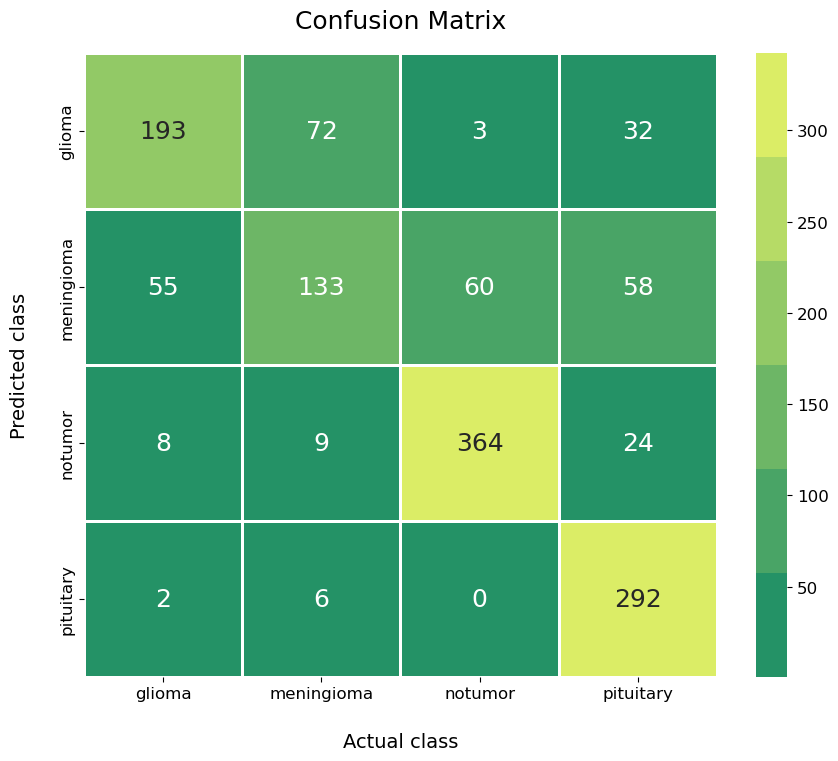

In [52]:
# Generating the confusion matrix of Resnet50 model
testDir = './Dataset/Testing'
classes = sorted(os.listdir(testDir))

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("summer")  
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)
plt.yticks(va="center")
plt.title('Confusion Matrix - Resnet50',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

Thus, based on the evaluation matrices and accuracy plots it can be observed that transfer learning model with VGG16 architecture outperformed the remaining models.